# 病态no-iid

In [117]:
def merge(filename):
    # 构建两个目录中的文件路径
    file_path1 = os.path.join(dir1, filename)
    file_path2 = os.path.join(dir2, filename)

    df1 = pd.read_csv(file_path1)
    df2 = pd.read_csv(file_path2)
    
    # 合并两个DataFrame
    merged_df = pd.concat([df1, df2], axis=1)
    merged_df.columns=["FedProx "+i for i in "acc, precision, recall, f1, mcc".split(",")]+["FedCan "+i for i in "acc, precision, recall, f1, mcc".split(",")]
    merged_df.fillna(0, inplace=True)
    return merged_df

In [118]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# 示例使用
dir1 = '/home/raoxy/FedProx-PyTorch/'  # 第一个目录路径
dir2 = '/home/raoxy/FedCan/'  # 第二个目录路径
csv_files=[]
for filename in os.listdir(dir1):
    if "F1" in filename:
        csv_files.append(filename)

In [119]:
merge(csv_files[0])

,FedProx acc,FedProx precision,FedProx recall,FedProx f1,FedProx mcc,FedCan acc,FedCan precision,FedCan recall,FedCan f1,FedCan mcc
0,0.814075,0.733537,0.615145,0.433646,0.000000,0.847506,0.500000,0.923753,0.458730,0.0
1,0.891835,0.769823,0.960185,0.803049,0.000000,0.882670,0.500000,0.941335,0.468839,0.0
2,0.896362,0.580843,0.971389,0.607004,0.000000,0.887352,0.333333,0.962451,0.313438,0.0
3,0.998187,0.987985,0.999333,0.993548,0.980828,0.997993,0.500000,0.998997,0.499498,0.0
4,0.951043,0.649721,0.666489,0.657889,-0.005201,0.999489,0.333333,0.999830,0.333248,0.0


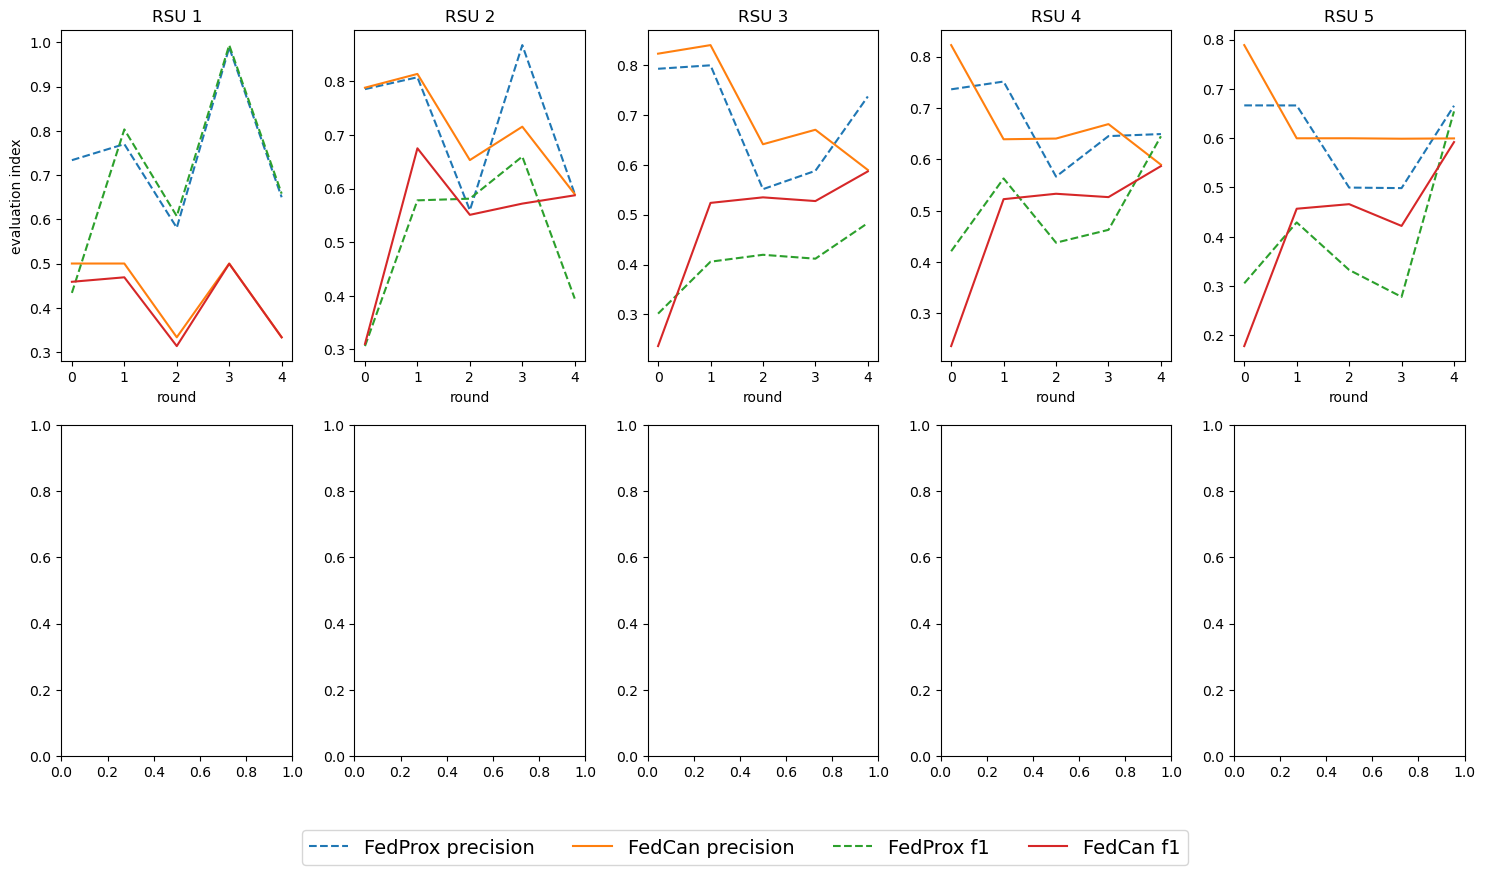

In [125]:
# Create subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 8))

# Plot data from each CSV file
for i, csv_file in enumerate(csv_files):
    df = merge(csv_file)
    ax = axs[i // 5, i % 5]
    
    # Plot line charts (customize as needed)
    # 绘制折线图，使用虚线表示 FedProx 的指标
    ax.plot(df["FedProx  precision"], label="FedProx precision", linestyle='--')
    ax.plot(df["FedCan  precision"], label="FedCan precision")
    ax.plot(df["FedProx  f1"], label="FedProx f1", linestyle='--')
    ax.plot(df["FedCan  f1"], label="FedCan f1")
    
    ax.set_title(f"RSU {i+1}")
    ax.set_xlabel("round")
    if i in [0, 5, 9, 14]:
        ax.set_ylabel("evaluation index")

# Get legend handles and labels from the first subplot
handles, labels = axs[0, 0].get_legend_handles_labels()

# 在大图的底部添加一个共同的图例
fig.legend(["FedProx precision", "FedCan precision", "FedProx f1", "FedCan f1"],
           loc="lower center", ncol=5, bbox_to_anchor=(0.5, -0.1),prop={'size': 14})

# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

# 测试模型精度

In [58]:
from torch.utils.data import DataLoader
import torchvision
from model import CNN,ResNet,VGG,Alexnet
import torch
from get_data import carHacking_Data

class Args:
    def __init__(self):
        self.B = 200
        self.root = '/home/raoxy/data/carhacking_our_bt'
        self.optimizer = "adam"
        self.lr = 0.05
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.weight_decay = 0.0001
        self.E = 10
        self.gamma = 0.1
        self.step_size = 100


args = Args()

# m,_ = Alexnet()
# state_dict = torch.load('/home/raoxy/FedProx-PyTorch/pth/preAlexNetbest.pth')
# m.load_state_dict(state_dict)

# m,_ = VGG()
# state_dict = torch.load('/home/raoxy/FedProx-PyTorch/pth/preVGGbest.pth')
# m.load_state_dict(state_dict)

# m,_ = ResNet()
# state_dict = torch.load('/home/raoxy/FedProx-PyTorch/pth/preResNetbest.pth')
# m.load_state_dict(state_dict)

# m= CNN(num_class=5)
# state_dict = torch.load('/home/raoxy/FedProx-PyTorch/pth/preCNNbest.pth')
# m.load_state_dict(state_dict)


m= CNN(num_class=5)
state_dict = torch.load('/home/raoxy/FedCan/model/CNN.pth')
m.load_state_dict(state_dict)


m.name = "car_12"
m.to(args.device)
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
Val  = DataLoader(
        torchvision.datasets.ImageFolder(root=args.root+"/"+m.name+"/train",
                                         transform=torchvision.transforms.ToTensor()),
        batch_size=args.B,
        shuffle=True, **kwargs)

RuntimeError: Error(s) in loading state_dict for CNN:
	Missing key(s) in state_dict: "block1.0.weight", "block1.0.bias", "block2.0.weight", "block2.0.bias", "block3.0.weight", "block3.0.bias". 
	Unexpected key(s) in state_dict: "fc.0.weight", "fc.0.bias", "fc.2.weight", "fc.2.bias". 

100%|██████████| 30/30 [00:00<00:00, 39.31it/s]

	准确率-Acc:0.9933161953727506
	查准率-TP/(TP+FP):0.9934931959401567
	召回率-TP/(TP+FN):0.9933161953727506
	F1:0.9933043011292998


<Figure size 1500x1500 with 0 Axes>

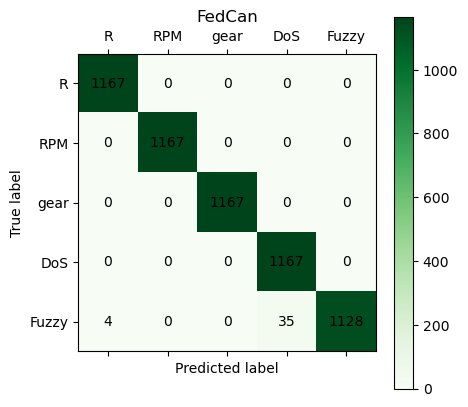

In [41]:
from dataset_create import Show_Info

sf=Show_Info()
sf.eval_model(m,Val,args.device,title="FedCan")

100%|██████████| 30/30 [00:00<00:00, 36.78it/s]

	准确率-Acc:0.894067067927773
	查准率-TP/(TP+FP):0.9264489892498968
	召回率-TP/(TP+FN):0.894067067927773
	F1:0.8846627427839729


<Figure size 1500x1500 with 0 Axes>

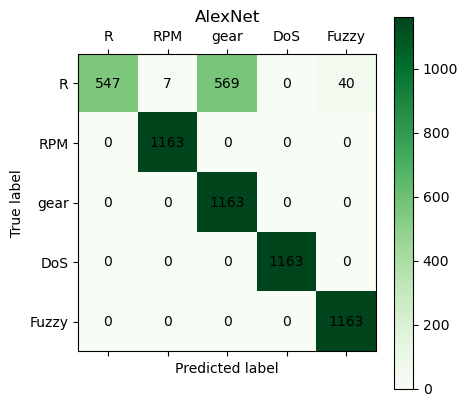

In [5]:
# AlexNet

100%|██████████| 30/30 [00:31<00:00,  1.05s/it]

	准确率-Acc:0.974548581255374
	查准率-TP/(TP+FP):0.9769740920315504
	召回率-TP/(TP+FN):0.974548581255374
	F1:0.9743469550200912


<Figure size 1500x1500 with 0 Axes>

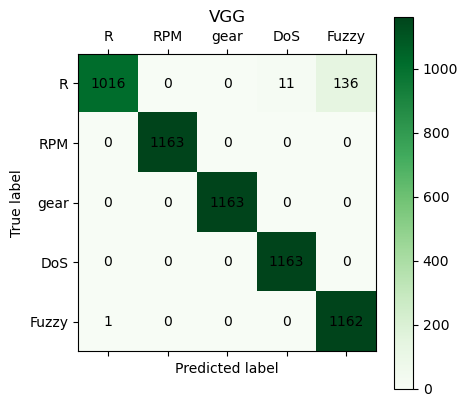

In [9]:
# VGG

100%|██████████| 30/30 [00:00<00:00, 37.22it/s]

	准确率-Acc:0.9955288048151333
	查准率-TP/(TP+FP):0.9956265769554247
	召回率-TP/(TP+FN):0.9955288048151333
	F1:0.9955282460810411


<Figure size 1500x1500 with 0 Axes>

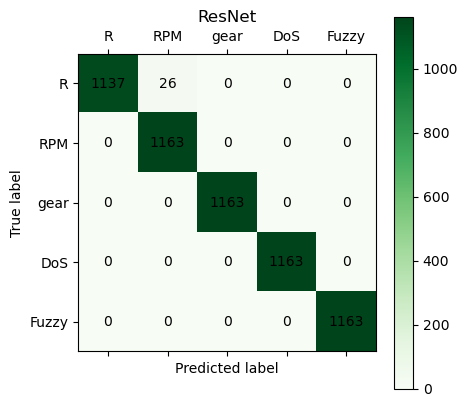

In [7]:
# ResNet

100%|██████████| 30/30 [00:00<00:00, 39.18it/s]

	准确率-Acc:0.961822871883061
	查准率-TP/(TP+FP):0.9674128187388567
	召回率-TP/(TP+FN):0.9618228718830611
	F1:0.9613221410963938


<Figure size 1500x1500 with 0 Axes>

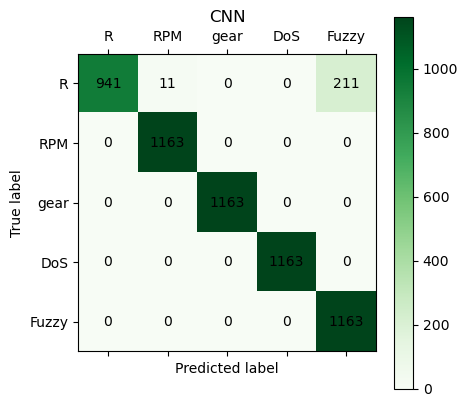

In [4]:
# CNN

# 查看数据集中的数据量

In [31]:
import os

# 根目录，包含5个小文件夹
root_directory = "/home/raoxy/data/carhacking/car_2/train/"

# 初始化一个字典，用于存储每个小文件夹的图片数量
image_counts = {}

# 遍历小文件夹
for folder_name in os.listdir(root_directory):
    folder_path = os.path.join(root_directory, folder_name)
    if os.path.isdir(folder_path):
        # 统计小文件夹中图片文件的数量
        image_count = len([filename for filename in os.listdir(folder_path) if filename.lower().endswith((".jpg", ".jpeg", ".png"))])
        image_counts[folder_name] = image_count

# 打印每个小文件夹的图片数量
for folder, count in image_counts.items():
    print(f"小文件夹 '{folder}' 包含 {count} 张图片。")

小文件夹 '1' 包含 1068 张图片。
小文件夹 '2' 包含 1064 张图片。
小文件夹 '3' 包含 1059 张图片。
小文件夹 '4' 包含 1016 张图片。
小文件夹 '0' 包含 1064 张图片。


# 查看loss曲线

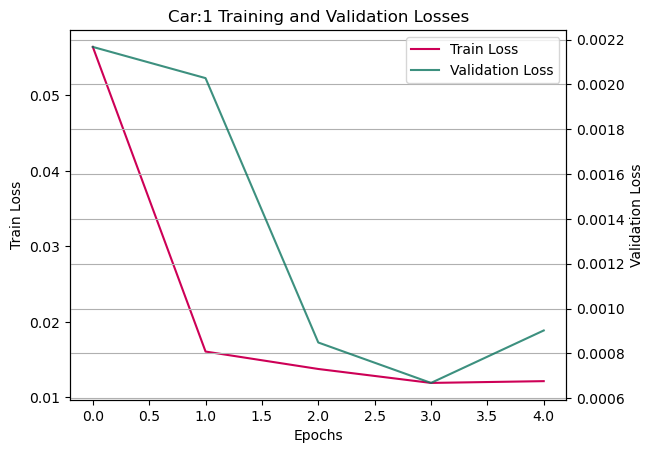

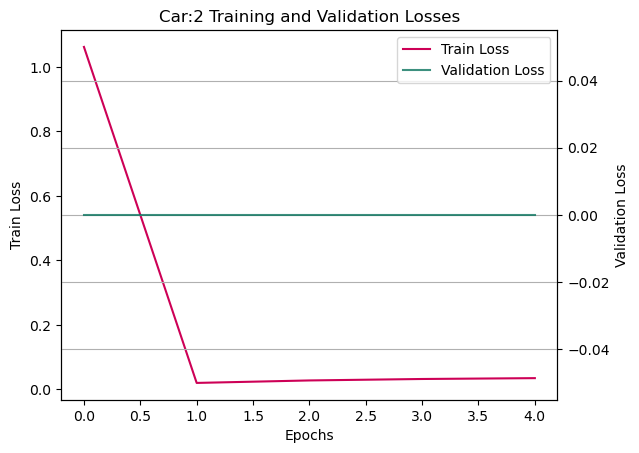

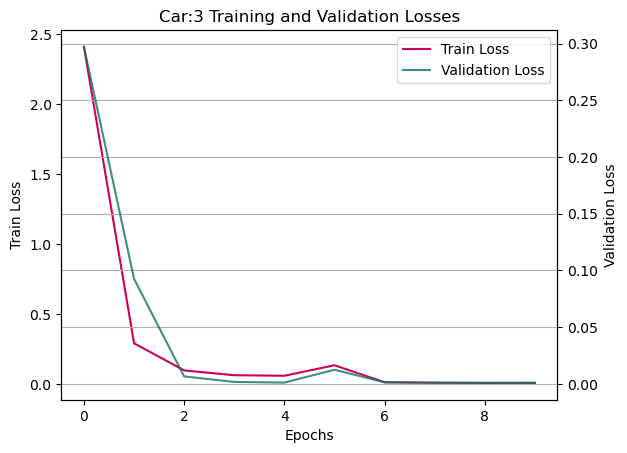

FileNotFoundError: [Errno 2] No such file or directory: '/home/raoxy/FedCan/csv/car_4.csv'

In [43]:
from dataset_create import Show_Info
import pandas as pd
sf=Show_Info()

for i in range(10):
    df=pd.read_csv("/home/raoxy/FedCan/csv/car_"+str(i+1)+".csv")
    sf.plot_losses(df, i+1)

# 测试狄利克雷

   ## 例子

In [127]:
def dirichlet_split_noniid(train_labels, alpha, n_clients):
    '''
    按照参数为alpha的Dirichlet分布将样本索引集合划分为n_clients个子集
    '''
    n_classes = train_labels.max()+1
    # (K, N) 类别标签分布矩阵X，记录每个类别划分到每个client去的比例
    label_distribution = np.random.dirichlet([alpha]*n_clients, n_classes)
    # (K, ...) 记录K个类别对应的样本索引集合
    class_idcs = [np.argwhere(train_labels == y).flatten()
                  for y in range(n_classes)]

    # 记录N个client分别对应的样本索引集合
    client_idcs = [[] for _ in range(n_clients)]
    for k_idcs, fracs in zip(class_idcs, label_distribution):
        # np.split按照比例fracs将类别为k的样本索引k_idcs划分为了N个子集
        # i表示第i个client，idcs表示其对应的样本索引集合idcs
        for i, idcs in enumerate(np.split(k_idcs,
                                          (np.cumsum(fracs)[:-1]*len(k_idcs)).
                                          astype(int))):
            client_idcs[i] += [idcs]

    client_idcs = [np.concatenate(idcs) for idcs in client_idcs]

    return client_idcs

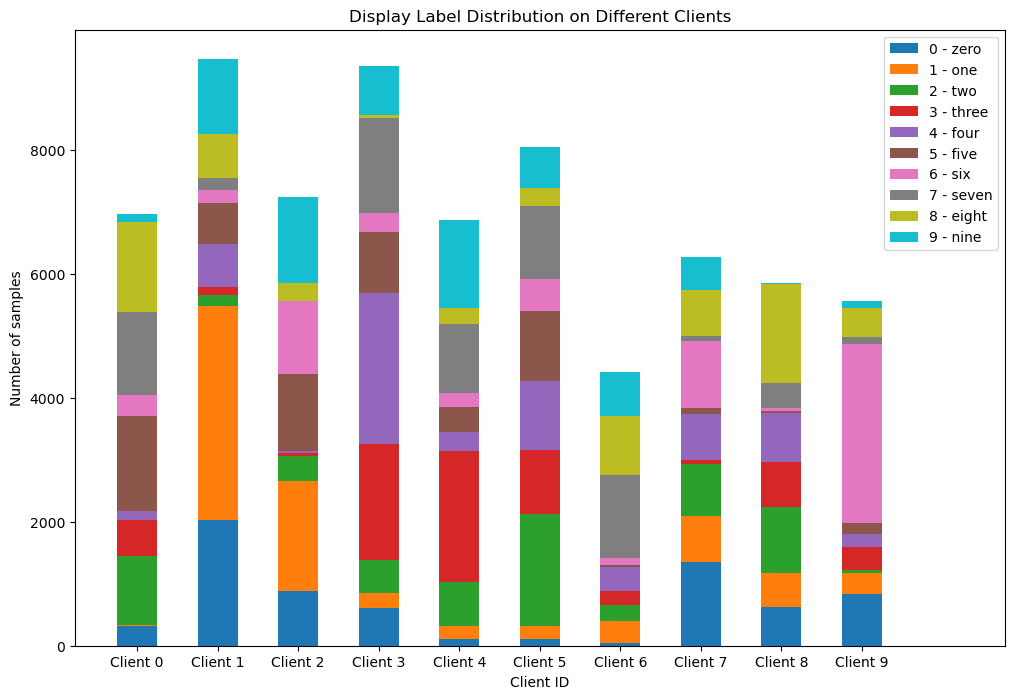

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import ConcatDataset


n_clients = 10
dirichlet_alpha = 1.0
seed = 42


np.random.seed(seed)
train_data = datasets.MNIST(
    root="~/data", download=True, train=True)
test_data = datasets.MNIST(
    root="~/data", download=True, train=False)

classes = train_data.classes
n_classes = len(classes)

labels = np.concatenate(
    [np.array(train_data.targets), np.array(test_data.targets)], axis=0)
dataset = ConcatDataset([train_data, test_data])

# 我们让每个client不同label的样本数量不同，以此做到Non-IID划分
client_idcs = dirichlet_split_noniid(
    labels, alpha=dirichlet_alpha, n_clients=n_clients)

# 展示不同client上的label分布
plt.figure(figsize=(12, 8))
label_distribution = [[] for _ in range(n_classes)]
for c_id, idc in enumerate(client_idcs):
    for idx in idc:
        label_distribution[labels[idx]].append(c_id)

plt.hist(label_distribution, stacked=True,
            bins=np.arange(-0.5, n_clients + 1.5, 1),
            label=classes, rwidth=0.5)
plt.xticks(np.arange(n_clients), ["Client %d" %
                                    c_id for c_id in range(n_clients)])
plt.xlabel("Client ID")
plt.ylabel("Number of samples")
plt.legend()
plt.title("Display Label Distribution on Different Clients")
plt.show()

## 实现

In [150]:
from get_data import carHacking_Data
from torch.utils.data import DataLoader
import torchvision
import torch

class Args:
    def __init__(self):
        self.B = 200
        self.root = '/home/raoxy/data/carhacking_our_bt'
        self.optimizer = "adam"
        self.lr = 0.05
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.weight_decay = 0.0001
        self.E = 10
        self.gamma = 0.1
        self.step_size = 100

args = Args()

use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data  = DataLoader(
        torchvision.datasets.ImageFolder(root=args.root+"/car_1/train",
                                         transform=torchvision.transforms.ToTensor()),
        batch_size=args.B,
        shuffle=True, **kwargs)

test_data  = DataLoader(
        torchvision.datasets.ImageFolder(root=args.root+"/car_1/test",
                                         transform=torchvision.transforms.ToTensor()),
        batch_size=args.B,
        shuffle=True, **kwargs)

In [155]:
class CustomMNIST(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

AttributeError: 'DataLoader' object has no attribute 'info'

In [152]:
classes = train_data.classes
n_classes = len(classes)

labels = np.concatenate(
    [np.array(train_data.targets), np.array(test_data.targets)], axis=0)
dataset = ConcatDataset([train_data, test_data])

# 我们让每个client不同label的样本数量不同，以此做到Non-IID划分
client_idcs = dirichlet_split_noniid(
    labels, alpha=dirichlet_alpha, n_clients=n_clients)

# 展示不同client上的label分布
plt.figure(figsize=(12, 8))
label_distribution = [[] for _ in range(n_classes)]
for c_id, idc in enumerate(client_idcs):
    for idx in idc:
        label_distribution[labels[idx]].append(c_id)

plt.hist(label_distribution, stacked=True,
            bins=np.arange(-0.5, n_clients + 1.5, 1),
            label=classes, rwidth=0.5)
plt.xticks(np.arange(n_clients), ["Client %d" %
                                    c_id for c_id in range(n_clients)])
plt.xlabel("Client ID")
plt.ylabel("Number of samples")
plt.legend()
plt.title("Display Label Distribution on Different Clients")
plt.show()

AttributeError: 'DataLoader' object has no attribute 'classes'

In [131]:
n_clients = 10
dirichlet_alpha = 1.0
seed = 42
np.random.seed(seed)
train_data = datasets.MNIST(
    root="~/data", download=True, train=True)
test_data = datasets.MNIST(
    root="~/data", download=True, train=False)

labels = np.concatenate(
    [np.array(train_data.targets), np.array(test_data.targets)], axis=0)
# Perform Dirichlet partition

In [134]:
import pandas as pd

df=pd.read_csv("/home/raoxy/data/Car_Hacking_100.csv").sample(frac=1, random_state=42)

In [139]:
df[:100]

,CAN ID,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
4535736,1349,216,0,0,135,0,0,0,0,R
7384451,1264,0,0,0,128,0,103,209,19,R
8792887,1349,216,0,0,137,0,0,0,0,R
9291794,809,134,191,127,20,17,32,0,20,R
9541616,809,220,183,127,20,17,32,0,20,R
...,...,...,...,...,...,...,...,...,...,...
10833768,809,12,190,127,20,17,32,0,20,R
2262900,790,69,41,36,255,41,36,0,255,RPM
7784724,809,220,184,126,20,17,32,0,20,R
11920287,399,254,89,0,0,0,60,0,0,R


In [140]:
# 分离特征和标签
X = df[:100].iloc[:, :-1]  # 前9列为特征
y = df[:100].iloc[:, -1]   # 最后一列为标签

In [ ]:
def dirichlet_split_noniid(train_labels, alpha, n_clients):
    '''
    按照参数为 alpha 的 Dirichlet 分布将样本索引集合划分为 n_clients 个子集
    '''
    n_classes = train_labels.max() + 1
    # 类别标签分布矩阵 X，记录每个类别划分到每个 client 的比例
    label_distribution = np.random.dirichlet([alpha] * n_clients, n_classes)
    # 记录 K 个类别对应的样本索引集合
    class_idcs = [np.argwhere(train_labels == y).flatten()
                  for y in range(n_classes)]

    # 记录 N 个 client 分别对应的样本索引集合
    client_idcs = [[] for _ in range(n_clients)]
    for k_idcs, fracs in zip(class_idcs, label_distribution):
        # np.split 按照比例 fracs 将类别为 k 的样本索引 k_idcs 划分为 N 个子集
        for i, idcs in enumerate(np.split(k_idcs, (np.cumsum(fracs)[:-1] * len(k_idcs)).astype(int))): client_idcs[i] += [idcs]

    client_idcs = [np.concatenate(idcs) for idcs in client_idcs]

    return client_idcs

In [144]:
# 使用Dirichlet分布划分数据集
def dirichlet_partition(X, y, num_partitions,alpha=1):
    # 生成Dirichlet分布的随机样本
    dirichlet_samples = np.random.dirichlet([alpha] * num_partitions, size=len(X))
    
    
    # 根据Dirichlet样本划分数据集
    partitions = []
    for i in range(num_partitions):
        partition_indices = np.where(np.argmax(dirichlet_samples, axis=1) == i)[0]
        partitions.append(X.iloc[partition_indices])
    
    return partitions

# 划分为10个小数据集
num_partitions = 10
partitions = dirichlet_partition(X,y, num_partitions)

In [146]:
pd.DataFrame(partitions)

,0,1,2,3,4,5,6,7,8,9
0,0.028865,0.048312,0.135738,0.082992,0.109785,0.022465,0.035867,0.326461,0.081920,0.127595
1,0.077334,0.108040,0.005700,0.267862,0.050444,0.121590,0.112264,0.042662,0.010264,0.203839
2,0.055036,0.064287,0.040737,0.061176,0.047238,0.158944,0.104785,0.335325,0.011886,0.120586
3,0.026638,0.370868,0.051996,0.149285,0.076667,0.253745,0.002122,0.032746,0.026636,0.009297
4,0.008770,0.093896,0.153786,0.027628,0.098157,0.116554,0.062035,0.157240,0.277160,0.004774
...,...,...,...,...,...,...,...,...,...,...
95,0.035898,0.259135,0.021268,0.191170,0.152127,0.029864,0.105232,0.015784,0.022723,0.166799
96,0.172822,0.010203,0.020626,0.235866,0.132056,0.103896,0.036373,0.087103,0.124278,0.076776
97,0.011513,0.023602,0.208096,0.106971,0.036188,0.070470,0.108019,0.008873,0.076914,0.349352
98,0.160281,0.004210,0.138585,0.153519,0.152904,0.079566,0.001656,0.058033,0.001178,0.250069


In [136]:
# 保存每个小数据集为CSV文件
for i, partition in enumerate(partitions):
    partition_filename = f"partition_{i+1}.csv"
    partition.to_csv(partition_filename, index=False)
    print(f"Saved {partition_filename}")

print("Data partitioning completed.")

Saved partition_1.csv
Saved partition_2.csv
Saved partition_3.csv
Saved partition_4.csv
Saved partition_5.csv
Saved partition_6.csv
Saved partition_7.csv
Saved partition_8.csv
Saved partition_9.csv
Saved partition_10.csv
Data partitioning completed.


In [148]:
import numpy as np
import pandas as pd

def dirichlet_split_noniid(train_labels, alpha, n_clients):
    n_classes = train_labels.max() + 1
    label_distribution = np.random.dirichlet([alpha] * n_clients, n_classes)
    class_idcs = [np.argwhere(train_labels == y).flatten() for y in range(n_classes)]
    client_idcs = [[] for _ in range(n_clients)]

    for k_idcs, fracs in zip(class_idcs, label_distribution):
        for i, idcs in enumerate(np.split(k_idcs, (np.cumsum(fracs)[:-1] * len(k_idcs)).astype(int))):
            client_idcs[i] += [idcs]
    client_idcs = [np.concatenate(idcs) for idcs in client_idcs]
    return client_idcs

# 读取CSV文件
# df = pd.read_csv('your_dataset.csv')
features = df.columns[:-1]  # 假设最后一列是标签

# 对每个特征进行Dirichlet划分
for feature in features:
    train_labels = df[feature].values
    client_idcs = dirichlet_split_noniid(train_labels, alpha=0.5, n_clients=10)  # alpha值可以根据需要调整
    

In [149]:
client_idcs

[array([      0,       2,       5, ..., 1576021, 1576040, 1576046]),
 array([ 755302,  755303,  755304, ..., 3451639, 3451663, 3451678]),
 array([1598808, 1598809, 1598811, ..., 3685927, 3685953, 3685967]),
 array([1977372, 1977374, 1977376, ..., 3870792, 3870807, 3870809]),
 array([2012066, 2012067, 2012070, ..., 5229591, 5229593, 5229595]),
 array([7752068, 7752070, 7752072, ..., 5735706, 5735707, 5735713]),
 array([12298343, 12298346, 12298347, ...,  5744138,  5744147,  5744158]),
 array([12575796, 12575797, 12575799, ...,  5932065,  5932066,  5932080]),
 array([13254900, 13254901, 13254902, ...,  7277704,  7277713,  7277719]),
 array([13688994, 13688996, 13688997, ..., 13724425, 13724449, 13724460])]

In [147]:
    # 将划分的索引用于创建小的CSV文件
    for i, idcs in enumerate(client_idcs):
        df.iloc[idcs].to_csv(f'{feature}_split_{i}.csv', index=False)

AttributeError: 'DataFrame' object has no attribute 'Label'

In [ ]:
# 展示不同client上的label分布
plt.figure(figsize=(12, 8))
label_distribution = [[] for _ in range(n_classes)]
for c_id, idc in enumerate(client_idcs):
    for idx in idc:
        label_distribution[labels[idx]].append(c_id)

plt.hist(label_distribution, stacked=True,
            bins=np.arange(-0.5, n_clients + 1.5, 1),
            label=classes, rwidth=0.5)
plt.xticks(np.arange(n_clients), ["Client %d" %
                                    c_id for c_id in range(n_clients)])
plt.xlabel("Client ID")
plt.ylabel("Number of samples")
plt.legend()
plt.title("Display Label Distribution on Different Clients")
plt.show()